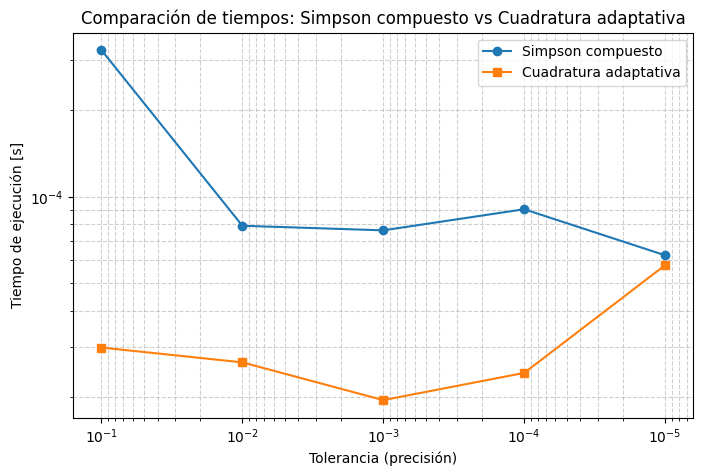

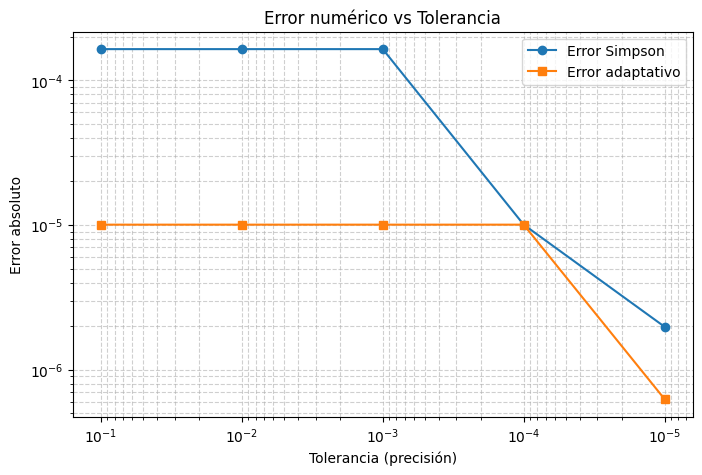

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ============================================================
# 1 Método compuesto de Simpson
# ============================================================

# Calcula la integral usando la regla compuesta de Simpson
def simpson_compuesto(f, a, b, n):
    if n % 2 != 0:
        n += 1  # Simpson requiere un número par de intervalos
    h = (b - a) / n
    x = np.linspace(a, b, n + 1)
    y = f(x)
    # Fórmula del método de Simpson compuesto
    S = y[0] + y[-1] + 4 * np.sum(y[1:-1:2]) + 2 * np.sum(y[2:-2:2])
    return (h / 3) * S

# Calcula cuántos intervalos n se necesitan según la tolerancia (usando la fórmula del error de Simpson)
def calcular_n_simpson(tol, a=0, b=1):
    f4_max = 1  # valor máximo de la cuarta derivada de sin(x)
    n = (( (b - a)**5 * f4_max ) / (180 * tol)) ** 0.25
    n = int(np.ceil(n))
    if n % 2 != 0:
        n += 1
    return n

# ============================================================
# 2 Método de cuadratura adaptativa
# ============================================================

# Excepción en caso de alcanzar el número máximo de iteraciones
class MaxIterations(Exception):
    pass

# Implementación del método de cuadratura adaptativa
def adaptive(f, a, b, tol, N=100_000):
    # Listas que almacenan información de cada subintervalo
    approx = 0
    i = 0
    toli = [10 * tol]             # tolerancia local
    ai = [a]                      # extremos inferiores
    hi = [(b - a) / 2]            # mitad del ancho del intervalo
    fai = [f(a)]                  # f(a)
    fbi = [f(b)]                  # f(b)
    fci = [f(a + hi[i])]          # f(punto medio)
    S0i = [hi[i] * (fai[i] + 4 * fci[i] + fbi[i]) / 3]  # Simpson inicial
    Li = [1]                      # nivel de subdivisión

    # Bucle que divide los intervalos hasta cumplir la tolerancia
    while i >= 0:
        # Calcula Simpson en cada mitad del intervalo
        fd = f(ai[i] + hi[i] / 2)
        fe = f(ai[i] + 3 * hi[i] / 2)
        S1 = hi[i] * (fai[i] + 4 * fd + fci[i]) / 6
        S2 = hi[i] * (fci[i] + 4 * fe + fbi[i]) / 6

        # Guarda los valores actuales para reutilizarlos si se subdivide
        ai_prec, hi_prec, fai_prec, fbi_prec, fci_prec = ai[i], hi[i], fai[i], fbi[i], fci[i]
        toli_prec, S0i_prec, Li_prec = toli[i], S0i[i], Li[i]

        i -= 1  # retrocede en la pila

        # Si el error local está dentro de la tolerancia, se suma al resultado
        if abs(S1 + S2 - S0i_prec) < toli_prec:
            approx += S1 + S2
        else:
            # Si no, divide el intervalo en dos y repite
            if Li_prec >= N:
                raise MaxIterations("Alcanzado máximo número de iteraciones.")

            # Intervalo derecho
            i += 1
            if i >= len(ai):
                ai.append(ai_prec + hi_prec)
                fai.append(fci_prec)
                fci.append(fe)
                fbi.append(fbi_prec)
                hi.append(hi_prec / 2)
                toli.append(toli_prec / 2)
                S0i.append(S2)
                Li.append(Li_prec + 1)
            else:
                ai[i] = ai_prec + hi_prec
                fai[i] = fci_prec
                fci[i] = fe
                fbi[i] = fbi_prec
                hi[i] = hi_prec / 2
                toli[i] = toli_prec / 2
                S0i[i] = S2
                Li[i] = Li_prec + 1

            # Intervalo izquierdo
            i += 1
            if i >= len(ai):
                ai.append(ai_prec)
                fai.append(fai_prec)
                fci.append(fd)
                fbi.append(fci_prec)
                hi.append(hi[i - 1])
                toli.append(toli[i - 1])
                S0i.append(S1)
                Li.append(Li[i - 1])
            else:
                ai[i] = ai_prec
                fai[i] = fai_prec
                fci[i] = fd
                fbi[i] = fci_prec
                hi[i] = hi[i - 1]
                toli[i] = toli[i - 1]
                S0i[i] = S1
                Li[i] = Li[i - 1]

    return approx

# ============================================================
# 3 Comparación de tiempos de ambos métodos
# ============================================================

f = np.sin
a, b = 0, 1
tolerancias = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

tiempos_simpson = []
tiempos_adapt = []
errores_simpson = []
errores_adapt = []

# Valor exacto de la integral de sin(x) entre 0 y 1: 1 - cos(1)
valor_real = 1 - np.cos(1)

# Calcula los tiempos y errores para cada tolerancia
for tol in tolerancias:
    # Simpson compuesto
    n = calcular_n_simpson(tol, a, b)
    start = time.time()
    I_simpson = simpson_compuesto(f, a, b, n)
    tiempos_simpson.append(time.time() - start)
    errores_simpson.append(abs(I_simpson - valor_real))

    # Cuadratura adaptativa
    start = time.time()
    I_adapt = adaptive(f, a, b, tol)
    tiempos_adapt.append(time.time() - start)
    errores_adapt.append(abs(I_adapt - valor_real))

# ============================================================
# 4 Gráficos comparativos
# ============================================================

# Gráfico: tiempo vs precisión (escala logarítmica)
plt.figure(figsize=(8,5))
plt.loglog(tolerancias, tiempos_simpson, 'o-', label='Simpson compuesto')
plt.loglog(tolerancias, tiempos_adapt, 's-', label='Cuadratura adaptativa')
plt.gca().invert_xaxis()
plt.xlabel("Tolerancia (precisión)")
plt.ylabel("Tiempo de ejecución [s]")
plt.title("Comparación de tiempos: Simpson compuesto vs Cuadratura adaptativa")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()

# Gráfico: error numérico vs tolerancia
plt.figure(figsize=(8,5))
plt.loglog(tolerancias, errores_simpson, 'o-', label='Error Simpson')
plt.loglog(tolerancias, errores_adapt, 's-', label='Error adaptativo')
plt.gca().invert_xaxis()
plt.xlabel("Tolerancia (precisión)")
plt.ylabel("Error absoluto")
plt.title("Error numérico vs Tolerancia")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.6)
plt.show()
